# Goals

To uncover the interplay between NER annotations and coref annotations. Specifically can finding NER directly lead to an estimation of num of clusters, do they all act as an antecedent?

# Specifics

1. Try to find num. mentions per coref cluster
2. Try to coalasce NER mentions (within one coref cluster) into one 'entity' and re-do this exp.
3. Try to do this coalasce thing globally within one document.

In [1]:
# Imports
import spacy
import numpy as np
import seaborn as sns
from thefuzz import fuzz
from pprint import pprint
from copy import deepcopy
from tqdm.auto import tqdm
from spacy.tokens import Doc
from collections import Counter
from typing import List, Tuple, Dict, Union
from scipy.stats import norm


from utils.misc import pop
from utils.data import Document
from dataloader import DataLoader
from utils.nlp import to_toks, remove_pos, NullTokenizer, is_nchunk


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [3]:
from analysis.ne_coref import *

In [4]:
summary = {}
nlp = spacy.load('en_core_web_sm')
# This tokenizer DOES not tokenize documents.
# Use this is the document is already tokenized.
nlp.tokenizer = NullTokenizer(nlp.vocab)
dl = DataLoader('ontonotes', 'train', ignore_empty_coref=True)

In [5]:
summary['ignored_instances'] = 0
summary['num_instances'] = len(dl)
summary['tokens_per_doc'] = []
summary['clusters_per_doc'] = []
summary['elements_per_cluster'] = []
summary['named_entities_per_doc'] = []
summary['named_entities_per_tag'] = []

summary['named_entities_unmatched_per_doc'] = []
summary['named_entities_unmatched_per_tag'] = []
summary['clusters_unmatched_per_doc'] = []
summary['clusters_matched_per_doc'] = []
ignored = 0

for i, doc in enumerate(tqdm(dl)):

    if not doc.named_entities_gold:
        summary['ignored_instances'] += 1
        continue

    # Get the spacy doc object for this one. It will be needed. Trust me.
    # noinspection PyTypeChecker
    spacy_doc = nlp(to_toks(doc.document))

    # Find the number of tokens in a document
    summary['tokens_per_doc'].append(len(to_toks(doc.document)))
    
    # Find statistics on the number of elements per cluster
    cardinalities = count_cluster_cardinality(doc)
    summary['elements_per_cluster'] += cardinalities

    # Find statistics on the number of coref clusters in one document
    summary['clusters_per_doc'].append(count_doc_n_clusters(doc))

    # Find statistics on the number of named entities in a document
    summary['named_entities_per_doc'].append(count_doc_n_entities(doc))

    # Find statistics on the number of named entities per named entity tags
    summary['named_entities_per_tag'] += count_tag_n_entities(doc)

    matches, unmatched = match_entities_to_coref_clusters(doc, spacy_doc)
    unmatched_clusters = [k for k, v in matches.items() if not v]
    matched_clusters = [k for k, v in matches.items() if v]
    summary['named_entities_unmatched_per_doc'].append(len(unmatched))
    summary['named_entities_unmatched_per_tag'] += [tupl[0] for tupl in unmatched]

    summary['clusters_unmatched_per_doc'].append(len(unmatched_clusters))
    summary['clusters_matched_per_doc'].append(len(matched_clusters))

# Plotting Time

In [29]:
def plot_avec_gauss(data: list, bins=None, xlabel: str= None, ylabel: str = None, plot_gauss: bool = True):
    """ 
        Assumes data is a list of integers 
        If not, it would create a key and "encode" every element with an integer.
    """
    
    sns.set_theme()
    
    
    vocab = {}
    freq = Counter(data)
    if type(data[0]) is not int:

        # We can also sort these things by the freq with which they appear
        freq = Counter(data)

        freq = dict(sorted(freq.items(), key=lambda kv: - kv[1]))
        vocab = {k: i for i, k in enumerate(freq.keys())}
        data = deepcopy(data)

        for i, datum in enumerate(data):
            data[i] = vocab[datum]


    bins = bins if bins else max(data)

    #     fig = plt.figure(figsize=(6,4))
    #     fig.set_dpi(150.0)
    #     plt.hist(data, bins=bins, density=True, alpha=0.6, color='b') #, x='Clusters in One Document', y='Frequency')

    fig = plt.figure(figsize=(6,4))
    fig.set_dpi(150.0)

    ax = fig.add_subplot(111, label="Hist")
    ax2 = fig.add_subplot(111, label="Mean", frame_on=False)
    ax.hist(data, bins=bins)


    if plot_gauss:
        mean, std = norm.fit(data)
        xmin, xmax = 0, max(data)
        x = np.linspace(xmin, xmax, bins*5)
        p = norm.pdf(x, mean, std)

        ax2.plot(x, p, 'k', linewidth=1)
        ax2.set_xticks([])
        ax2.set_yticks([])

    if xlabel:
        ax.set_xlabel(xlabel)

    if ylabel:
        ax.set_ylabel(ylabel)

    ax.tick_params(axis='x')
    ax.tick_params(axis='y')

    if vocab:
        plt.xticks(ticks=range(len(vocab)), labels=vocab.keys(), rotation=90, fontsize=8, color='green')


    plt.show()

    
def plot_avec_mean(data: list, bins=None, xlabel: str= None, ylabel: str = None, 
                   plot_mean: bool = True, xlog: bool = False, ylog: bool = False, 
                  ignore_outliers: int = 0):
    vocab = {}

    sns.set_style("white")

    freq = Counter(data)
    if type(data[0]) is not int:

        # We can also sort these things by the freq with which they appear
        freq = Counter(data)

        freq = dict(sorted(freq.items(), key=lambda kv: - kv[1]))
        vocab = {k: i for i, k in enumerate(freq.keys())}
        data = deepcopy(data)

        for i, datum in enumerate(data):
            data[i] = vocab[datum]

            
    if ignore_outliers:
        data = deepcopy(data)
        mean = np.mean(data)
        std = np.std(data)
        popids = [i for i, val in enumerate(data) 
                  if not (mean - ignore_outliers*std) <= val <= (mean + ignore_outliers*std)]
        pop(data, popids)

    bins = bins if bins else max(data)

    fig = plt.figure(figsize=(6,4))
    fig.set_dpi(150.0)

    ax = fig.add_subplot(111, label="Hist")
    ax.hist(data, bins=bins)

    if plot_mean:
        mean = np.mean(data)
        ax.axvline(mean, color = 'r', linestyle = 'dashed', linewidth = 1)

    if xlabel:
        ax.set_xlabel(xlabel)

    if ylabel:
        ax.set_ylabel(ylabel)

#     ax.tick_params(axis='x')
#     ax.tick_params(axis='y')

    if vocab:
        plt.xticks(ticks=range(len(vocab)), labels=vocab.keys(), rotation=90, fontsize=8, color='green')

    if xlog and not vocab:
        ax.set_xscale('log')
    #     ax.set_xticks([2, 4, 6, 10, 20, 50, 100])

    if ylog and not vocab:
        ax.set_yscale('log')
        plt.xticks(ticks=range(0, max(data), int(np.std(data))), labels=range(0, max(data), int(np.std(data))))

    plt.grid(True, which="both", ls="-")
    plt.show()
    
    
def plot_dist(data: list, bins=None, xlabel: str= None, ylabel: str = None, log: bool = False):
    vocab = {}
    
    sns.set_theme()
    sns.set_style("whitegrid")
    
    freq = Counter(data)
    freq = dict(sorted(freq.items(), key=lambda kv: - kv[1]))
    
    if log:
        log_freqv = np.log(list(freq.values()))
        freq = {k:v for k, v in zip(freq.keys(), log_freqv)}
    
    fig = plt.figure(figsize=(6,4))
    fig.set_dpi(150.0)

    ax = fig.add_subplot(111, label="Hist")
    plt.xticks(ticks=range(len(freq)), labels=freq.keys(), rotation=90, fontsize=8, color='green' )
    ax.bar(range(len(freq)), freq.values())

    if log:
        ax.set_yscale('log')
    
    if xlabel:
        ax.set_xlabel(xlabel)

    if ylabel:
        ax.set_ylabel(ylabel)

    plt.show()
    

# Token Length Distribution
Are the documents of similar sizes? How varied are they?

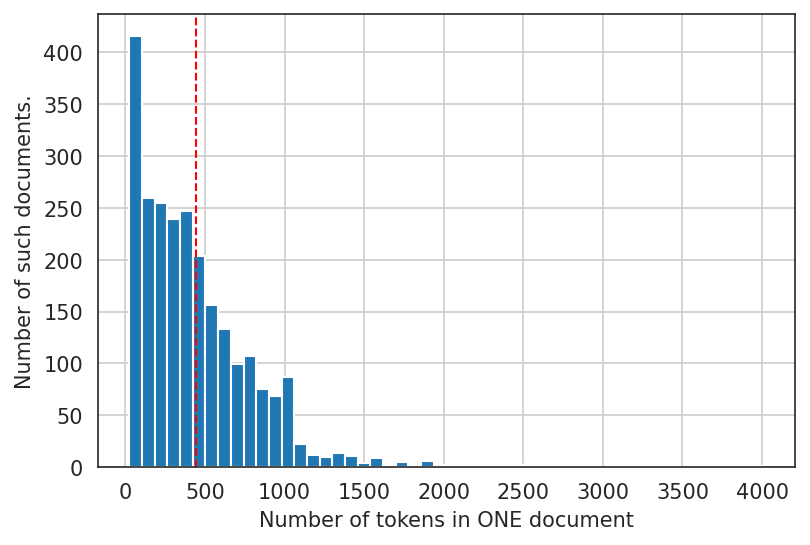

In [7]:
plot_avec_mean(summary['tokens_per_doc'], bins=50,
    xlabel="Number of tokens in ONE document",
    ylabel="Number of such documents.")

# Coref Cluster Cardinality
Here, you can see the number of elements contained in coref clusters. 

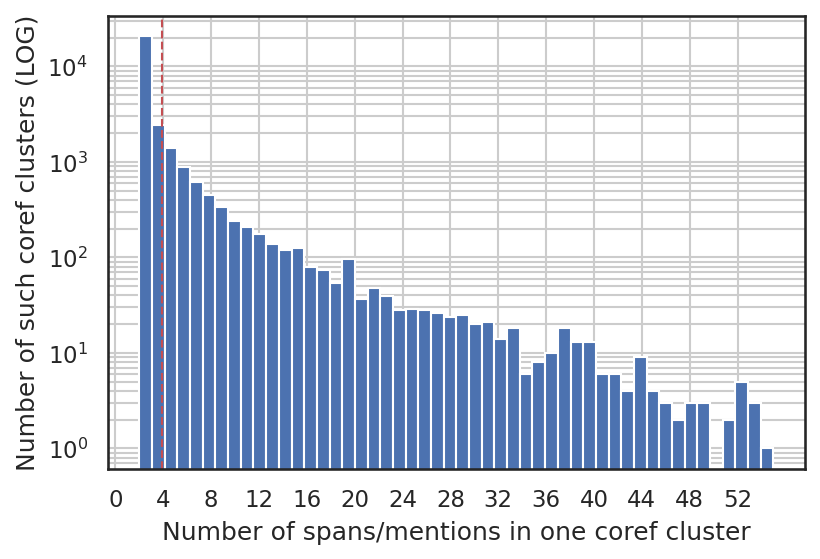

In [33]:
plot_avec_mean(summary['elements_per_cluster'],
              xlabel="Number of spans/mentions in one coref cluster",
              ylabel="Number of such coref clusters (LOG)", bins=50, ylog=True, ignore_outliers=10, plot_mean=True)

# Coref Cluster Distribution
In the first plot, we a distribution of number of coreference clusters in a document. This should give us an idea of how long tailed the distribution is, and how much memory do we aim to allocate per document.

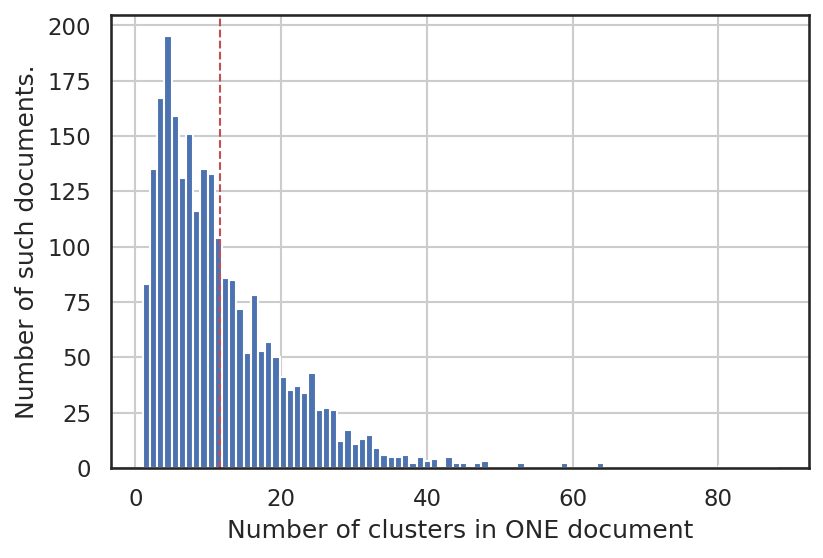

In [30]:
plot_avec_mean(summary['clusters_per_doc'],
    xlabel="Number of clusters in ONE document",
    ylabel="Number of such documents.")

# Named Entity Distribution
Here, we do a similar plot denoting the number of named entities found in a plot. Obviously, this serves little purpose except to illustrate the general distribution of entities.

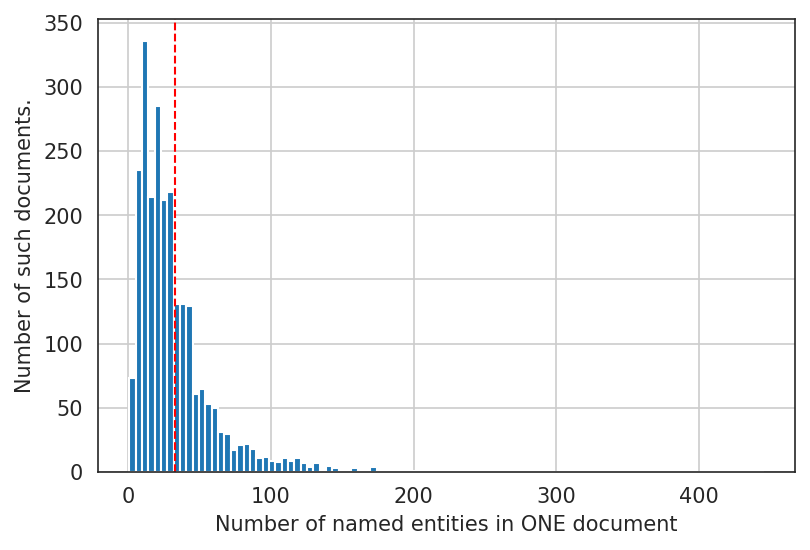

In [10]:
plot_avec_mean(summary['named_entities_per_doc'], bins=100,
    xlabel="Number of named entities in ONE document",
    ylabel="Number of such documents.")

# Named Entity Distribution by Tags
Which kind of named entities appear most often. 

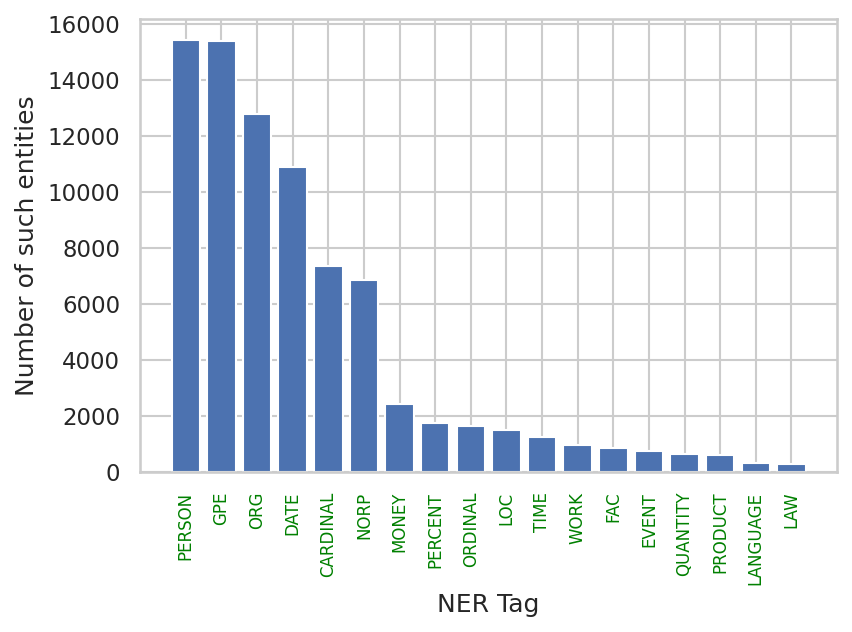

In [11]:
plot_dist(summary['named_entities_per_tag'],
    xlabel="NER Tag",
    ylabel="Number of such entities", log=False)

# Named Entity Distribution (clustered or not)
The same plot as above, except the clustered and unclustered variants of each kind of entities are plain to see.

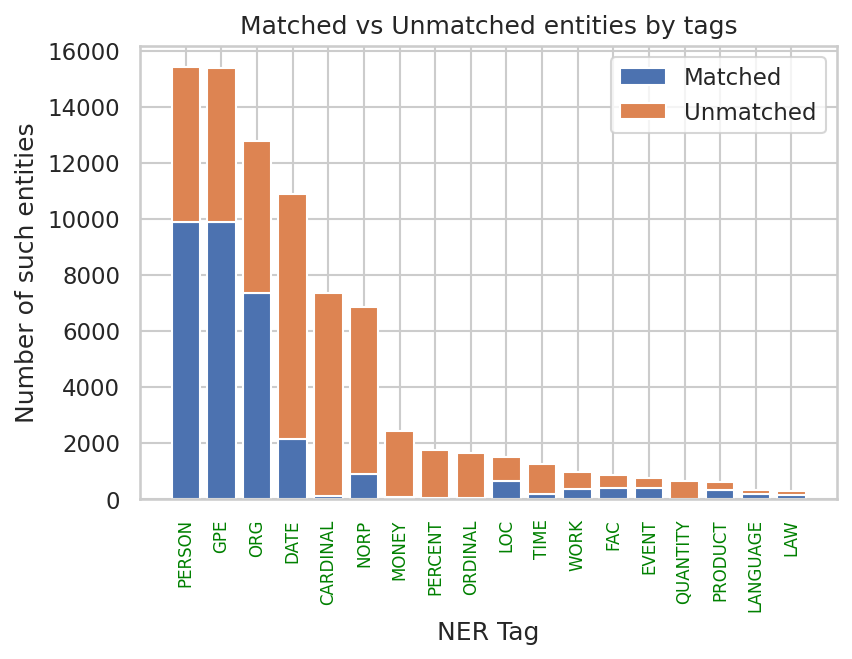

In [12]:
if True:
    unmatched_tags = Counter(summary['named_entities_unmatched_per_tag'])
    total_tags = Counter(summary['named_entities_per_tag'])
    sorted_total_tags = dict(sorted(total_tags.items(), key=lambda kv: - kv[1]))
    sorted_unmatched_tags = {k: unmatched_tags[k] for k in sorted_total_tags.keys()}
    sorted_matched_tags = {k: v1-v2 for k, v1, v2 in zip(sorted_total_tags.keys(), sorted_total_tags.values(), sorted_unmatched_tags.values())}


    sorted_unmatched_tags, sorted_matched_tags


    sns.set_theme()
    sns.set_style("whitegrid")


    fig = plt.figure(figsize=(6,4))
    fig.set_dpi(150.0)

    ax = fig.add_subplot(111, label="Hist")

    ax.bar(range(len(sorted_matched_tags)), sorted_matched_tags.values(), label="Matched")
    ax.bar(range(len(sorted_matched_tags)), sorted_unmatched_tags.values(), label="Unmatched", bottom=list(sorted_matched_tags.values()))
    ax.set_title("Matched vs Unmatched entities by tags")
    ax.legend()

    plt.xticks(ticks=range(len(sorted_matched_tags)), labels=sorted_matched_tags.keys(), rotation=90, fontsize=8, color='green' )

    ax.set_xlabel("NER Tag")

    ax.set_ylabel("Number of such entities")

# Relevant Numbers

In [13]:
# Number of clusters with no entities
total_clusters = np.sum()
print("Total Clusters in Train Set: {}")


# Scratchpad